In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal 
import datetime as dt

In [2]:
ord_items_df = pd.read_csv('/Users/Ian/Downloads/archive/order_items.csv')
ord_df = pd.read_csv('/Users/Ian/Downloads/archive/orders.csv')

In [17]:
def data_cleaning(order_items_df, orders_df):
    '''
    This function takes the order_items and the orders tables, aggregates the order_items table,
    merges the tables, cleans the datatypes and returns the cleaned dataframe
    '''
    # Convert the created_at column from object to datetime
    
    order_sales = order_items_df[['order_id','sale_price']].groupby(by='order_id').sum('sale_price').reset_index()
    order_sales = order_sales.merge(orders_df[['order_id','user_id','created_at']]).set_index('order_id')
    
    order_sales['created_at'] = pd.to_datetime(order_sales.created_at,format='mixed').dt.tz_localize(None)

    return order_sales

In [33]:
clean_df = data_cleaning(ord_items_df,ord_df)
clean_df.sample(9)

,sale_price,user_id,created_at
order_id,,,
86645,146.000000,69075,2022-09-19 13:32:00
90030,30.600000,71757,2023-08-21 02:26:00
938,24.950001,754,2022-06-07 01:07:00
33123,23.700001,26527,2023-05-06 13:06:00
78141,69.980001,62343,2023-05-13 17:37:00
48387,74.989998,38718,2021-06-27 14:47:00
103057,159.000000,82294,2023-11-13 15:07:00
23055,9.200000,18407,2022-08-07 03:31:00
23894,44.000000,19080,2021-02-22 09:24:00


In [19]:
def rfm(cleaned_order_items_df):
    '''
    This function takes the cleaned order_items dataframe and outputs the Recency, Frequency and Tenure dataframe
    '''
    return summary_data_from_transaction_data(transactions = cleaned_order_items_df,
                                              customer_id_col = 'user_id',
                                              datetime_col = 'created_at',
                                              monetary_value_col = 'sale_price')

The **recency** variable is a measure of the time elapsed since the customer’s last purchase.

The **frequency** corresponds to the number of orders placed by a customer.

The **monetary** metric shows the total revenue generated by each customer.

Tenure, or **T**, represents how long a given customer has been with the company.

In [20]:
# def train_test_separation(clean_df):

# time_diff = clean_df.created_at.max() - clean_df.created_at.min()  # work out how many days range in the dataset
# train_test_ratio = 0.05  # choose the fraction to use as test

train_start = pd.to_datetime('2019-01-01')
train_end = pd.to_datetime('2020-12-31')
test_end = pd.to_datetime('2021-03-31')

# get the subset of the data, restricted by train period plus test period
clean_df_subset = clean_df[(clean_df.created_at>=train_start) & (clean_df.created_at<=test_end)]

# use the calibration_and_holdout_data method in lifetimes package to separate the time series data    
separated_df = calibration_and_holdout_data(transactions=clean_df_subset, 
                                            customer_id_col="user_id",
                                            datetime_col = "created_at",
                                            monetary_value_col= 'sale_price',
                                            calibration_period_end=train_end,
                                            observation_period_end=test_end)

# return separated_df

In [34]:
separated_df.sample(9)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases,CLV,sq_error
user_id,,,,,,,,,,
2462,0.0,0.0,589.0,0.0,0.0,0.0,90.0,0.028284,2.527670,6.389116
47268,0.0,0.0,178.0,0.0,0.0,0.0,90.0,0.047984,4.288647,18.392491
5221,0.0,0.0,284.0,0.0,0.0,0.0,90.0,0.040673,3.635055,13.213626
38073,0.0,0.0,113.0,0.0,0.0,0.0,90.0,0.053933,4.820526,23.237469
1713,0.0,0.0,241.0,0.0,0.0,0.0,90.0,0.043352,3.874538,15.012047
5985,1.0,43.0,78.0,396.0,0.0,0.0,90.0,0.096869,23.626206,558.197623
13548,0.0,0.0,99.0,0.0,0.0,0.0,90.0,0.055414,4.952888,24.531097
2140,0.0,0.0,176.0,0.0,0.0,0.0,90.0,0.048147,4.303251,18.517973
75446,0.0,0.0,178.0,0.0,0.0,0.0,90.0,0.047984,4.288647,18.392491


___

In [22]:
def train_model(rfm_train_df):
    pen_coef_ = 0.01
    model = BetaGeoFitter(penalizer_coef=pen_coef_)
    model.fit(rfm_train_df['frequency_cal'],
              rfm_train_df['recency_cal'],
              rfm_train_df['T_cal'],)
    print("✅ ß-Geo Model trained")
    return model

In [23]:
model = train_model(separated_df)

✅ ß-Geo Model trained


In [46]:
clean_df_subset

,sale_price,user_id,created_at
order_id,,,
13,471.539986,9,2020-05-23 17:44:00
24,173.959999,17,2019-06-15 12:17:00
25,552.579987,17,2020-10-29 12:17:00
26,21.450001,17,2020-09-18 12:17:00
40,24.990000,29,2020-03-19 18:29:00
...,...,...,...
125182,107.099998,99962,2021-02-05 12:56:00
125200,38.970001,99976,2019-06-13 09:19:00
125216,199.000000,99990,2020-08-30 08:26:00


In [79]:
new_user = pd.DataFrame(columns=clean_df.columns)
new_user.loc[0] = {'sale_price':45,'user_id':'X','created_at':'2020-08-30 08:26:00'}
new_user.loc[1] = {'sale_price':70,'user_id':'X','created_at':'2020-09-07 08:26:00'}
new_user

,sale_price,user_id,created_at
0,45,X,2020-08-30 08:26:00
1,70,X,2020-09-07 08:26:00


In [82]:
new_user_rfm = rfm(new_user)

In [35]:
# Predicting the number of purchases in the next 90 days for all customers
separated_df['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(90,
                                                                                                separated_df['frequency_cal'],
                                                                                                separated_df['recency_cal'],
                                                                                                separated_df['T_cal']
                                                                                               )

In [25]:
rfm_df_filtered = separated_df[separated_df.monetary_value_cal>0]
gg_model = GammaGammaFitter()
gg_model.fit(rfm_df_filtered['frequency_cal'], rfm_df_filtered['monetary_value_cal']);

In [26]:
separated_df['CLV'] = gg_model.customer_lifetime_value(model,
                                                      separated_df['frequency_cal'],
                                                      separated_df['recency_cal'],
                                                      separated_df['T_cal'],
                                                      separated_df['monetary_value_cal'],
                                                      time = 3,# In months
                                                     )

In [84]:
gg_model.customer_lifetime_value(model,
                                 new_user_rfm['frequency'],
                                 new_user_rfm['recency'],
                                 new_user_rfm['T'],
                                 new_user_rfm['monetary_value'],
                                 time = 3,# In months
                                )

user_id
X    9.534303
Name: clv, dtype: float64

In [29]:
separated_df['sq_error'] = (separated_df.monetary_value_holdout - separated_df.CLV)**2
print("Root mean square error: "+str(np.sqrt(separated_df['sq_error'].mean())))
separated_df

Root mean square error: 31.413368982331484


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases,CLV,sq_error
user_id,,,,,,,,,,
9,0.0,0.0,222.0,0.000000,0.0,0.0,90.0,0.044651,3.990733,15.925953
17,2.0,502.0,565.0,287.014994,0.0,0.0,90.0,0.184069,40.540735,1643.551177
29,0.0,0.0,287.0,0.000000,0.0,0.0,90.0,0.040498,3.619449,13.100413
46,0.0,0.0,148.0,0.000000,0.0,0.0,90.0,0.050557,4.518718,20.418808
60,0.0,0.0,250.0,0.000000,0.0,0.0,90.0,0.042762,3.821833,14.606407
...,...,...,...,...,...,...,...,...,...,...
99952,0.0,0.0,219.0,0.000000,0.0,0.0,90.0,0.044864,4.009722,16.077867
99976,0.0,0.0,567.0,0.000000,0.0,0.0,90.0,0.028919,2.584439,6.679324
99990,0.0,0.0,123.0,0.000000,0.0,0.0,90.0,0.052923,4.730245,22.375220


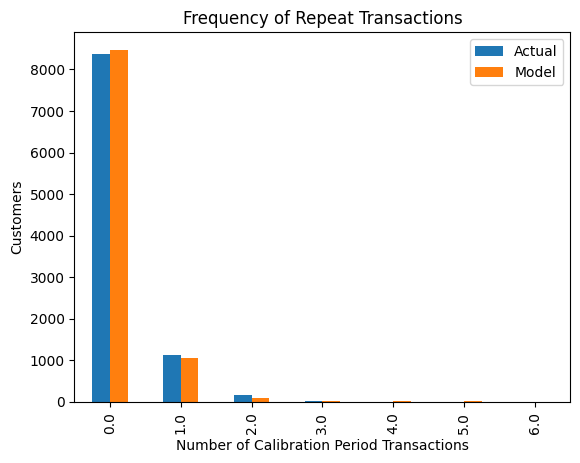

In [30]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(model);

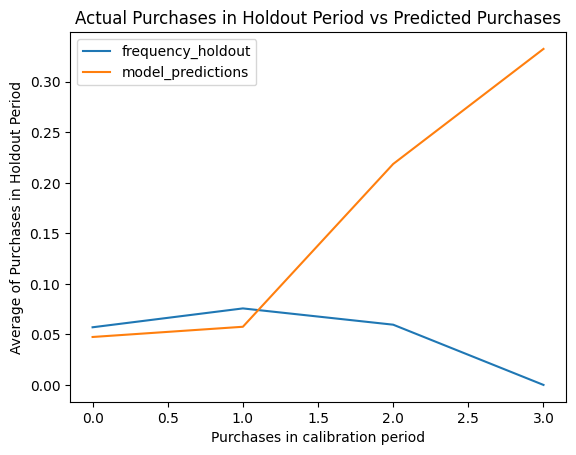

In [31]:
plot_calibration_purchases_vs_holdout_purchases(model,separated_df);

### Need to do model tuning